In [1]:
import torch
import pyro.distributions as dist
import pyro
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer import Predictive, infer_discrete, TraceEnum_ELBO, config_enumerate, SVI
from pyro.infer.autoguide import AutoNormal
from pyro.ops.indexing import Vindex
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
print(pyro.__version__)

1.8.2+2e3bd02


In [2]:
initial_probs = torch.tensor([0.5, 0.5])
transition_matrix = torch.tensor([[0.95, 0.05], 
                               [0.10, 0.90]])
emission_probs = torch.tensor([[1/6,  1/6,  1/6,  1/6,  1/6,  1/6],    # fair die
                            [1/10, 1/10, 1/10, 1/10, 1/10, 5/10]])  # loaded die

print(f"A.shape: {transition_matrix.shape}")
print(f"B.shape: {emission_probs.shape}")

A.shape: torch.Size([2, 2])
B.shape: torch.Size([2, 6])


In [3]:
hmm = dist.DiscreteHMM(
    initial_logits=initial_probs.log(),
    transition_logits=transition_matrix.log(),
    observation_dist=dist.Categorical(emission_probs),
    duration=50
    )

emission = hmm.sample()

In [4]:
emission

tensor([1, 1, 3, 3, 5, 5, 2, 1, 3, 1, 2, 2, 4, 4, 2, 5, 4, 0, 1, 1, 0, 1, 1, 4,
        0, 3, 5, 5, 1, 4, 1, 4, 2, 5, 3, 1, 1, 5, 1, 1, 3, 4, 5, 2, 4, 4, 4, 4,
        3, 0])

In [ ]:
for t, y in pyro.markov(enumerate(emission)):
    print(t, y)

In [77]:
@config_enumerate
def hmm_model(ys):

    x = 0  # initial state
    for t, y in pyro.markov(enumerate(ys)):
        x = pyro.sample(f"x_{t}", dist.Categorical(transition_matrix[x]),
                        infer={"enumerate": "parallel"})
        pyro.sample(f"y_{t}", dist.Categorical(emission_probs[x]), obs=y)
        print(f"x_{t}.shape = {x.shape}")

In [90]:
hmm_guide = AutoNormal(
    pyro.poutine.block(
        hmm_model, 
        expose_fn=lambda msg: msg["name"].startswith("x_")
        )
    )

In [91]:
#hmm_guide = AutoNormal(pyro.poutine.block(hmm_model))
elbo = TraceEnum_ELBO(max_plate_nesting=0)
elbo.loss(hmm_model, hmm_guide, emission)

ValueError: Continuous inference cannot handle discrete sample site 'x_0'. Consider enumerating that variable as documented in https://pyro.ai/examples/enumeration.html . If you are already enumerating, take care to hide this site when constructing an autoguide, e.g. guide = AutoNormal(poutine.block(model, hide=['x_0'])).
Trace Shapes:
 Param Sites:
Sample Sites:
Trace Shapes:
 Param Sites:
Sample Sites:
Trace Shapes:
 Param Sites:
Sample Sites:

In [62]:
#@infer_discrete(first_available_dim=-1, temperature=0)
@config_enumerate
def model_1(xs):
    z = pyro.sample('z_init', dist.Categorical(initial_probs))
    states = [0]
    for t, y in pyro.markov(enumerate(xs)):
        z = pyro.sample(
            f'z_{t}', 
            dist.Categorical(Vindex(transition_matrix)[..., z, :]),
            infer={"enumerate": "parallel"}
            )
        emissions = pyro.sample(
            f"y_{t}", 
            dist.Categorical(Vindex(emission_probs)[..., z, :]),
            obs=xs[t]
            )

    return z

In [81]:
hmm_guide = AutoNormal(pyro.poutine.block(model_1))
elbo = TraceEnum_ELBO(max_plate_nesting=0)
elbo.loss(model_1, hmm_guide, emission)

91.2457504272461

In [ ]:
#pyro.render_model(model_1, (emission,), render_distributions=True)

In [82]:
# nuts_kernel = NUTS(model_1, jit_compile=True, ignore_jit_warnings=True)
# mcmc = MCMC(nuts_kernel, num_samples=300, warmup_steps=100)
# mcmc.run(emission)

Sample: 100%|██████████| 400/400 [00:00, 10849.28it/s, step size=1.00e+00, acc. prob=1.000]


In [74]:
serve = infer_discrete(model_1, first_available_dim=-1, temperature=0)
latent_states = torch.Tensor(serve(emission))
latent_states

tensor(0)

In [ ]:
def model():

    emissions = pyro.sample("emissions", dist.DiscreteHMM(
        initial_logits=torch.logit(initial_probs),
        transition_logits=torch.logit(transition_matrix),
        observation_dist=dist.Categorical(emission_probs),
        duration=50
    ), infer={"enumerate": "sequential"})

    return emissions

In [ ]:
# serve = infer_discrete(model, first_available_dim=-1, temperature=0)
# serve()

In [ ]:
#post_states = hmm.filter(emission).sample([50])

In [25]:
one_hot = torch.nn.functional.one_hot(emission, 6).T

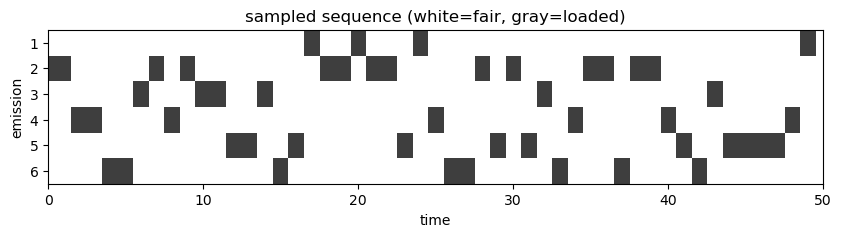

In [26]:
plt.figure(figsize=(10, 2))
plt.imshow(one_hot, aspect="auto", interpolation="none", cmap="Greys")
# plt.imshow(post_states[None, :], extent=(0, 50, 6-.5, -.5), 
#                interpolation="none", aspect="auto", cmap="Greys", alpha=0.25)
plt.imshow(
    latent_states[None, :], extent=(0, 50, 6-.5, -.5), 
    interpolation="none", aspect="auto", cmap="Greys", alpha=0.25
    )
plt.xlabel("time")
plt.ylabel("emission")
plt.yticks(np.arange(6), np.arange(6) + 1)    # b/c python is zero indexed!
plt.title("sampled sequence (white=fair, gray=loaded)");